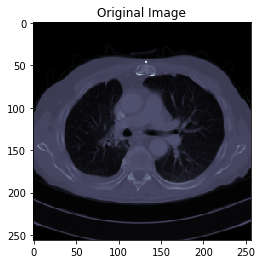

In [1]:
# Importing libraries

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
import pydicom
import os
import sys
import skimage 
import random
from scipy.spatial import distance
from skimage.segmentation import clear_border
import statistics

# Importing DICOM Images and storing them

path = r'C:\Users\akars\OneDrive\Desktop\CT Medical Images\dicom_dir'
files = [pydicom.dcmread(path + '/' + s) for s in sorted(os.listdir(path))]
size=256
images = [cv.resize(s.pixel_array,(size,size)) for s in files]

# Displaying the selected Original DICOM Image

gray=images[0]
plt.title('Original Image')
plt.imshow(gray,cmap=plt.cm.bone)
plt.show()
cv.imwrite(r'C:\Users\akars\OneDrive\Desktop\Original_Image.jpeg',gray)

# Obtaining HU values from original DICOM image

offset=1024
gray1=gray.astype(np.int16)-offset




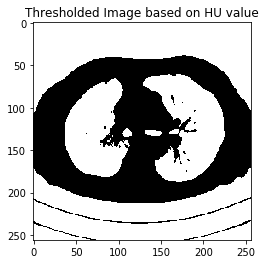

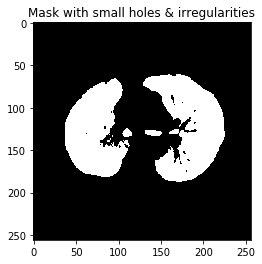

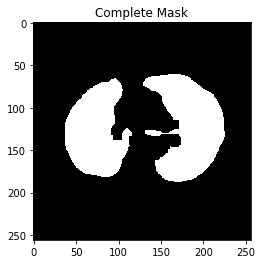

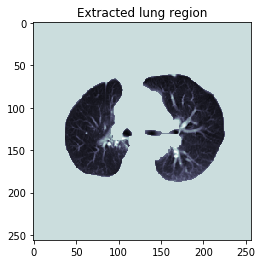

In [2]:
## Code for extracting lung region using a constructed mask

# Thresholding Dicom Image based on a predetermined threshold value i.e. -400

gray2=np.array(gray1)
for i in range(size):
    for j in range(size):
        if gray1[i][j]<-400:
            gray2[i][j]=255
        else:
            gray2[i][j]=0

# Displaying thresholded Dicom Image

plt.title('Thresholded Image based on HU value')
plt.imshow(gray2,cmap=plt.cm.bone)
plt.show()

# Mask creation followed by closing morphological operation

gray_3 = clear_border(gray2)
plt.title('Mask with small holes & irregularities')
plt.imshow(gray_3,cmap=plt.cm.bone)
plt.show()

kernel = np.ones((9,9),np.uint8)
gray_close= cv.morphologyEx(gray_3, cv.MORPH_CLOSE, kernel)
plt.title('Complete Mask')
plt.imshow(gray_close,cmap=plt.cm.bone)
plt.show()

# Obtaining extracted lung region with the help of the above created mask

gray_ex=np.array(gray1)
for i in range(size):
    for j in range(size):
        if gray_close[i][j]==255:
            pass
        else:
            gray_ex[i][j]=0

# Displaying extracted lung region

plt.title('Extracted lung region')  
plt.imshow(gray_ex,cmap=plt.cm.bone)
plt.show()

In [12]:
## Code for K-median and K-mean

# Selecting value for number of clusters 'k'

k=5

#Randomly initializing clusters centers

diff=0
dd=0
gray_f=np.zeros([size,size],dtype = np.uint8)
gray_f=list(gray1.flatten())

centers=[0,0]
while centers.count(0)>1 or diff==0:
    centers=random.sample(list(gray_f),k)
    diff=int(centers[0])-int(centers[1])
print(centers)


[-991, -1, -34, 61, -898]


17903
2911
9298
13659
21765

0 256 512 768 1024 1280 1536 1792 2048 2304 2560 2816 3072 3328 3584 3840 4096 4352 4608 4864 5120 5376 5632 5888 6144 6400 6656 6912 7168 7424 7680 7936 8192 8448 8704 8960 9216 9472 9728 9984 10240 10496 10752 11008 11264 11520 11776 12032 12288 12544 12800 13056 13312 13568 13824 14080 14336 14592 14848 15104 15360 15616 15872 16128 16384 16640 16896 17152 17408 17664 17920 18176 18432 18688 18944 19200 19456 19712 19968 20224 20480 20736 20992 21248 21504 21760 22016 22272 22528 22784 23040 23296 23552 23808 24064 24320 24576 24832 25088 25344 25600 25856 26112 26368 26624 26880 27136 27392 27648 27904 28160 28416 28672 28928 29184 29440 29696 29952 30208 30464 30720 30976 31232 31488 31744 32000 32256 32512 32768 33024 33280 33536 33792 34048 34304 34560 34816 35072 35328 35584 35840 36096 36352 36608 36864 37120 37376 37632 37888 38144 38400 38656 38912 39168 39424 39680 39936 40192 40448 40704 40960 41216 41472 41728 41984 42240 42496 42752 43008 432

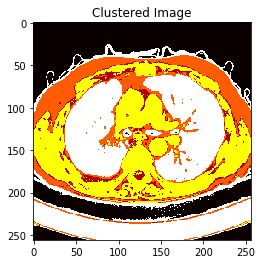


[-986, 8, -135, 127, -814]


True

In [13]:
# Using binary search when the final clusters formed need to be allocated distinct intensity values

def binary_search(array, x): 
    
    arr=np.sort(array)
    low = 0
    high = len(arr) - 1
    mid = 0
  
    while low <= high: 
  
        mid = (high + low) // 2
        if arr[mid] < x: 
            low = mid + 1
        elif arr[mid] > x: 
            high = mid - 1
        else: 
            return mid
    return -1
  
# Iteratively clustering the Dicom Image by using total_iterations as the stopping condition for the algorithm

total_iterations=0

while total_iterations<1:
    
    #Calculating manhattan/euclidean distance and storing it 
    
    mdist=[[[0 for z in range(len(gray))] for j in range(len(gray))] for i in range(k)]
    d=0
    for z in range(k):
        for i in range(size):
            for j in range(size):
                
                # Uncomment the value of d based on which algorithm you want to run
                # For k-mean use the euclidean one and for k-median use the other one
                
                #d=abs(int(gray1[i][j])-int(centers[z]))
                d=distance.euclidean(int(gray1[i][j]),int(centers[z]))
                mdist[z][i][j]=d

    #Clustering the pixel values in image based on minimum distance paramter from respective clusters that have been initiated
    
    cluster=[[] for i in range(k)]
    for i in range(size):
        for j in range(size):
            cx=0
            cl=0
            mm=100000
            for z in mdist:
                # Finding the minimum distance value and the cluster from which minimum distance is there
                if z[i][j]<mm:
                    nn=gray1[i][j]
                    mm=z[i][j]
                    cl=cx
                cx+=1
            
            # Appending pixel point to the cluster from which minimum distance is found
            cluster[cl].append(nn)
    
    # Printing the number of pixel points which have been segmented in their respective clusters
    
    for i in cluster:
        print(len(i))
    print()

    # Allocating distinct intensity values to the different clusters formed

    kernel = np.ones((3,3),np.uint8)
    gray_c = np.array(gray1)
    oc=0
    for i in range(size):
        #print(oc,end=' ')
        for j in range(size):
            if binary_search(cluster[0],int(gray1[i][j]))!=-1:
                gray_c[i][j] = 51
                oc += 1
            elif binary_search(cluster[1],int(gray1[i][j]))!=-1:
                gray_c[i][j] = 102
                oc += 1
            elif binary_search(cluster[2],int(gray1[i][j]))!=-1:
                gray_c[i][j] = 153
                oc += 1
            elif binary_search(cluster[3],int(gray1[i][j]))!=-1:
                gray_c[i][j] = 204
                oc += 1
            else:
                gray_c[i][j] = 255
                oc += 1
    
    # Displaying the segmented clustered image
    
    plt.title('Clustered Image')
    plt.imshow(gray_c,cmap='hot')
    plt.show()
    
    #Calculating new centroids for the next iterations
    
    gray_new=[]
    for i in cluster:
        
        # Uncomment the value of med based on which algorithm you want to run
        # For k-mean use the mean one and for k-median use the median one
        
        #med=int(statistics.median(i))
        med=int(statistics.mean(i))
        gray_new.append(med)
    
    # Printing new centroids calculated 
    
    print()
    print(gray_new)
    
    # Updating the centroids value in the centers array which will be used in the next iteration
    
    for i in range(len(gray_new)):
        centers[i]=gray_new[i]
        
    # Incrementing value of total_iterations once the entire clustering process is completed for the particular iteration
    
    total_iterations+=1

cv.imwrite(r'C:\Users\akars\OneDrive\Desktop\111.jpeg',gray_c)